In [10]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, load_digits, load_wine, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


In [15]:
# Greedy K-Center (2-factor)
def greedy_k_center(X, k):
    n = X.shape[0]
    centers_idx = [np.random.randint(0, n)]
    distances = np.full(n, np.inf)

    for _ in range(1, k):
        new_dist = np.linalg.norm(X - X[centers_idx[-1]], axis=1)
        distances = np.minimum(distances, new_dist)
        centers_idx.append(np.argmax(distances))

    centers = X[centers_idx]
    labels = np.argmin(cdist(X, centers), axis=1)
    return centers, labels


def k_center_cost(X, centers):
    d = cdist(X, centers)
    return np.max(np.min(d, axis=1))


In [16]:
def k_center_cost(X, centers):
    d = cdist(X, centers)
    return np.max(np.min(d, axis=1))

def local_search_k_center(X, k, max_iter=10):
    n = X.shape[0]

    # Step 1: Start with random k centers
    center_idx = list(np.random.choice(n, k, replace=False))

    centers = X[center_idx]
    best_cost = k_center_cost(X, centers)

    for _ in range(max_iter):

        improved = False

        # Step 2: Try all swaps (one center → one non-center)
        for ci in center_idx:
            for candidate in range(n):
                if candidate in center_idx:
                    continue

                # new set of centers after swap
                new_center_idx = center_idx.copy()
                new_center_idx.remove(ci)
                new_center_idx.append(candidate)

                new_centers = X[new_center_idx]
                new_cost = k_center_cost(X, new_centers)

                # accept swap if better
                if new_cost < best_cost:
                    best_cost = new_cost
                    center_idx = new_center_idx
                    improved = True
                    break  # break inner loop

            if improved:
                break   # break outer loop

        # if no improving swap → stop
        if not improved:
            break

    # final labels
    final_centers = X[center_idx]
    labels = np.argmin(cdist(X, final_centers), axis=1)

    return final_centers, labels


In [17]:
# Run on datasets
def run_dataset():
    np.random.seed(42)

    datasets = {
        'Blobs': make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)[0],
        'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=0)[0],
        'Digits': load_digits().data,
        'Wine': load_wine().data,
        'Cancer': load_breast_cancer().data
    }

    scaler = StandardScaler()
    results = []

    for name, data in datasets.items():
        X = scaler.fit_transform(data)

        for k in [3, 5, 7]:


            # Greedy 2-Approx
            start = time.time()
            centers_g, labels_g = greedy_k_center(X, k)
            cost_g = k_center_cost(X, centers_g)
            time_g = time.time() - start

            results.append({
                "Dataset": name,
                "Algorithm": "Greedy",
                "k": k,
                "Cost": cost_g,
                "Time": time_g
            })

            print(f"[Greedy] {name} | k={k} | cost={cost_g:.4f} | time={time_g:.4f}")


            # Local Search 2-Approx

            start = time.time()
            centers_l, labels_l = local_search_k_center(X, k)
            cost_l = k_center_cost(X, centers_l)
            time_l = time.time() - start

            results.append({
                "Dataset": name,
                "Algorithm": "LocalSearch",
                "k": k,
                "Cost": cost_l,
                "Time": time_l
            })

            print(f"[LocalSearch] {name} | k={k} | cost={cost_l:.4f} | time={time_l:.4f}")

    return pd.DataFrame(results), datasets


In [20]:
def plot_greedy_costs(df):
    greedy_df = df[df["Algorithm"] == "Greedy"]

    plt.figure(figsize=(10, 5))
    markers = ['o', 's', 'D', '^', 'v']  # different markers per dataset

    for i, dataset in enumerate(greedy_df["Dataset"].unique()):
        sub = greedy_df[greedy_df["Dataset"] == dataset]
        plt.plot(sub["k"], sub["Cost"], marker=markers[i], linewidth=2,
                 label=dataset)

    plt.title("Greedy K-Center Cost vs k")
    plt.xlabel("k")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_localsearch_costs(df):
    ls_df = df[df["Algorithm"] == "LocalSearch"]

    plt.figure(figsize=(10, 5))
    markers = ['o', 's', 'D', '^', 'v']  # different markers

    for i, dataset in enumerate(ls_df["Dataset"].unique()):
        sub = ls_df[ls_df["Dataset"] == dataset]
        plt.plot(sub["k"], sub["Cost"], marker=markers[i], linewidth=2,
                 label=dataset)

    plt.title("Local Search K-Center Cost vs k")
    plt.xlabel("k")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_cost_comparison(df):
    plt.figure(figsize=(10, 6))

    greedy = df[df["Algorithm"] == "Greedy"]
    ls = df[df["Algorithm"] == "LocalSearch"]

    markers_g = ['o', 's', 'D', '^', 'v']
    markers_l = ['x', '*', 'P', 'H', '>']

    datasets = df["Dataset"].unique()

    for i, dataset in enumerate(datasets):
        g = greedy[greedy["Dataset"] == dataset]
        l = ls[ls["Dataset"] == dataset]

        plt.plot(g["k"], g["Cost"], marker=markers_g[i], linestyle='-',
                 label=f"{dataset} - Greedy")
        plt.plot(l["k"], l["Cost"], marker=markers_l[i], linestyle='--',
                 label=f"{dataset} - LocalSearch")

    plt.title("Cost Comparison: Greedy vs Local Search")
    plt.xlabel("k")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.legend()
    plt.show()


In [21]:
def plot_time_comparison(df):
    plt.figure(figsize=(10, 6))

    greedy = df[df["Algorithm"] == "Greedy"]
    ls = df[df["Algorithm"] == "LocalSearch"]

    markers_g = ['o', 's', 'D', '^', 'v']
    markers_l = ['x', '*', 'P', 'H', '>']

    datasets = df["Dataset"].unique()

    for i, dataset in enumerate(datasets):
        g = greedy[greedy["Dataset"] == dataset]
        l = ls[ls["Dataset"] == dataset]

        plt.plot(g["k"], g["Time"], marker=markers_g[i], linestyle='-',
                 label=f"{dataset} - Greedy")
        plt.plot(l["k"], l["Time"], marker=markers_l[i], linestyle='--',
                 label=f"{dataset} - LocalSearch")

    plt.title("Runtime Comparison: Greedy vs Local Search")
    plt.xlabel("k")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.legend()
    plt.show()


[Greedy] Blobs | k=3 | cost=1.9711 | time=0.0002
[LocalSearch] Blobs | k=3 | cost=1.3095 | time=0.0908
[Greedy] Blobs | k=5 | cost=1.3226 | time=0.0002
[LocalSearch] Blobs | k=5 | cost=0.9968 | time=0.1190
[Greedy] Blobs | k=7 | cost=1.2654 | time=0.0007
[LocalSearch] Blobs | k=7 | cost=0.8939 | time=0.0683
[Greedy] Circles | k=3 | cost=2.1907 | time=0.0002
[LocalSearch] Circles | k=3 | cost=1.8187 | time=0.0010
[Greedy] Circles | k=5 | cost=1.4013 | time=0.0002
[LocalSearch] Circles | k=5 | cost=1.2608 | time=0.1056
[Greedy] Circles | k=7 | cost=1.3526 | time=0.0003
[LocalSearch] Circles | k=7 | cost=1.1663 | time=0.0876
[Greedy] Digits | k=3 | cost=45.2093 | time=0.0019
[LocalSearch] Digits | k=3 | cost=44.6858 | time=2.4745
[Greedy] Digits | k=5 | cost=31.5971 | time=0.0022
[LocalSearch] Digits | k=5 | cost=44.7563 | time=1.9465
[Greedy] Digits | k=7 | cost=28.8861 | time=0.0029
[LocalSearch] Digits | k=7 | cost=44.7061 | time=1.2783
[Greedy] Wine | k=3 | cost=7.1446 | time=0.0002
[

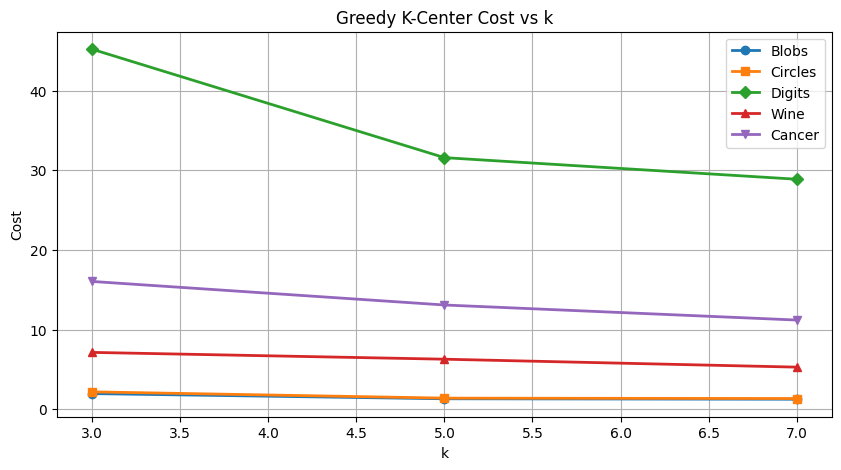

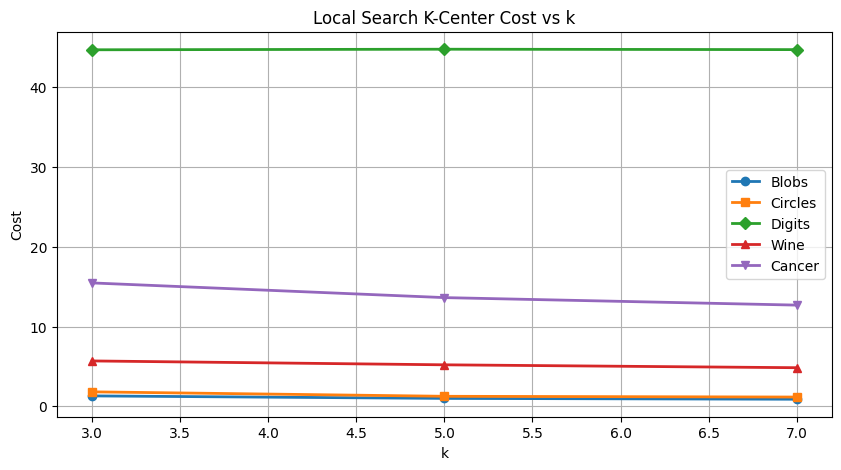

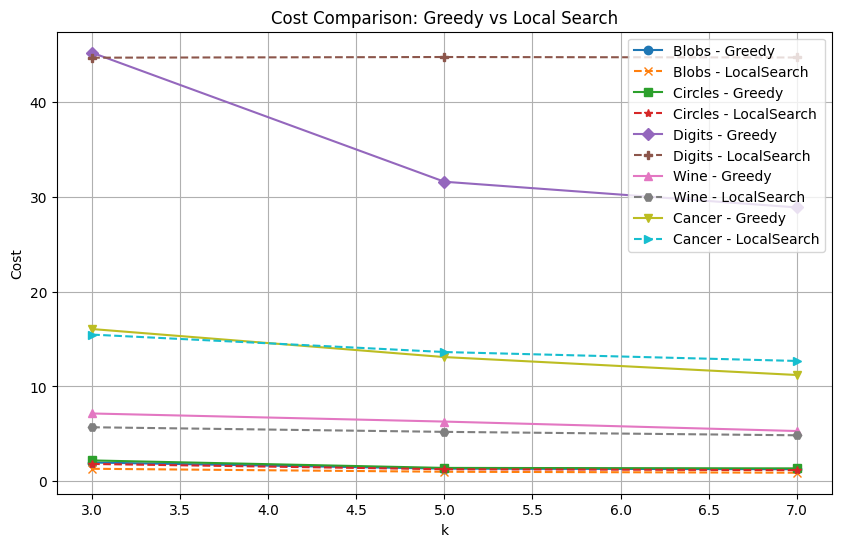

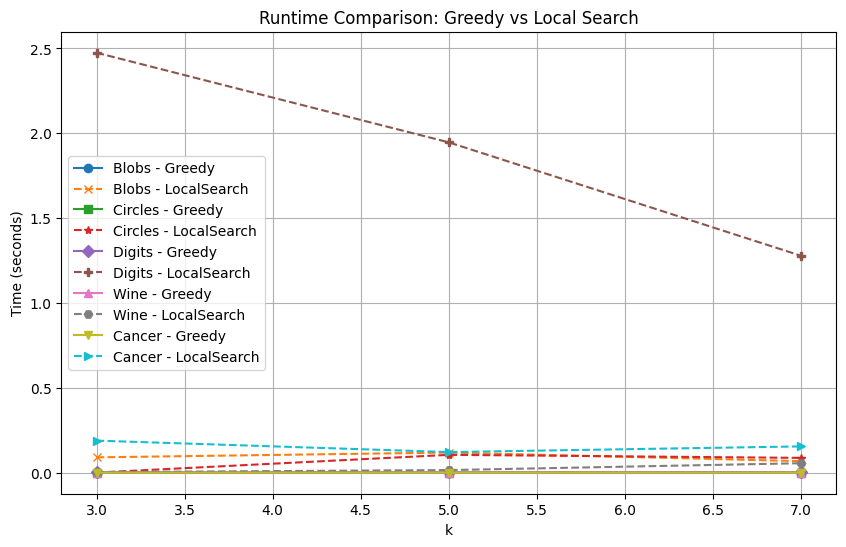

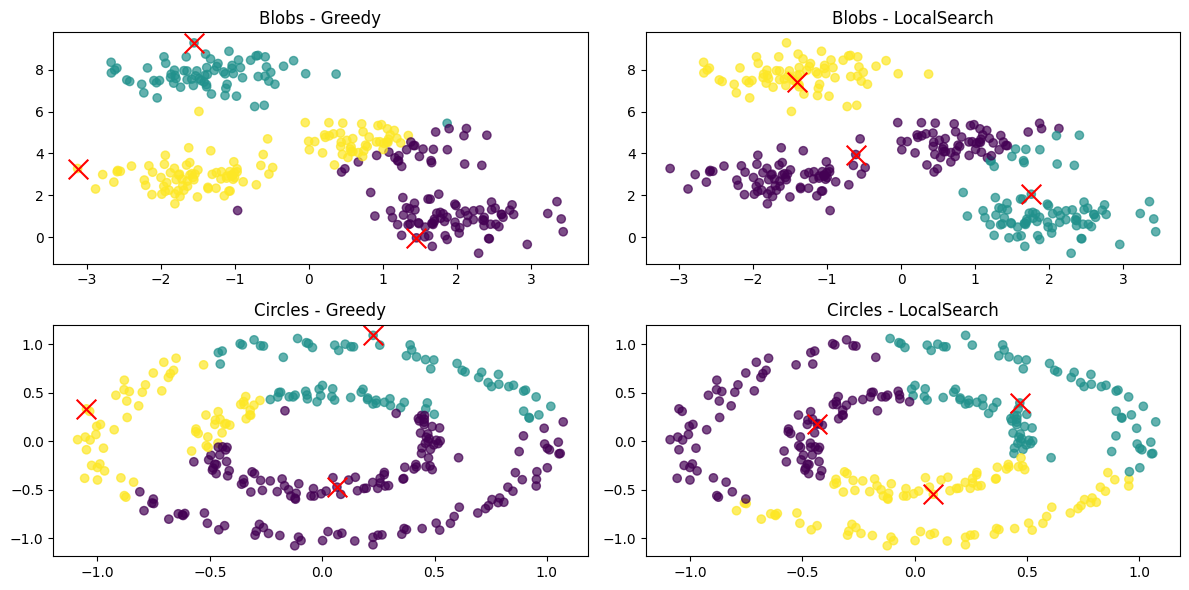

In [22]:
# Visualize clustering: Greedy vs Local Search on toy datasets

def visualize_toy(datasets):
    plt.figure(figsize=(12, 6))

    toy_sets = ["Blobs", "Circles"]
    algos = [("Greedy", greedy_k_center), ("LocalSearch", local_search_k_center)]

    plot_index = 1

    for name in toy_sets:
        X = datasets[name]

        for algo_name, algo_fn in algos:
            centers, labels = algo_fn(X, k=3)

            plt.subplot(2, 2, plot_index)
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", alpha=0.7)
            plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, marker="x")

            plt.title(f"{name} - {algo_name}")
            plot_index += 1

    plt.tight_layout()
    plt.show()




# Run algorithm
df, datasets = run_dataset()
plot_greedy_costs(df)
plot_localsearch_costs(df)
plot_cost_comparison(df)
plot_time_comparison(df)
visualize_toy(datasets)